## Tutorial 2: Using SSJ for Closed-economy Monetary Policy Analysis

NBER Heterogeneous-Agent Macro Workshop

Spring 2022

This tutorial walks us through setting up the monetary policy models that we covered in lecture.

What we'll do in a nutshell:

   1. Set up the model using blocks 
   2. Get the steady state
   3. Get the impulse responses to `r_ante` shocks, compare to the RA model
   4. Use Jacobians to decompose into direct/indirect effects
   5. Repeat steps 1-3 for our alternative models

 We'll start by importing our usual three packages.

In [1]:
# Import standard packages

import numpy as np  
import matplotlib.pyplot as plt 
import sequence_jacobian as sj  

We'll also import a `py` file that has some convenience plotting functions.

In [2]:
import tutorial_closed_econ_monetary as tutil

Here is our predefined `calibration` dictionary for this session.

In [3]:
calibration = {'eis': 0.5,     # EIS
               'rho_e': 0.92,  # Persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,   # Standard deviation of idiosyncratic productivity shocks
               'Y': 1.,        # Output
               'r_ante': 0.01, # target real interest rate
               'min_a': -1,    # Minimum asset level on the grid
               'max_a': 1_000, # Maximum asset level on the grid
               'n_a': 500,     # Number of asset grid points
               'n_e': 11}      # Number of productivity grid points

Because we already went over the canonical HANK model in Tutorial 1, here we'll instead follow what is actually a more common workflow in SSJ: load a predefined `HetBlock` and start working with that directly. 

We do this by preloading the household block and grid function from `sj.hetblocks.hh_sim` 

In [4]:
hh = sj.hetblocks.hh_sim.hh
make_grids = sj.hetblocks.hh_sim.make_grids

Now, we define the income input. For our baseline model, income is just $e\times Y$

In [5]:
def income(Y, e_grid):
    # post-tax labor income
    y = Y * e_grid
    return y

We're ready to define our simple `HetBlock`, with `make_grids` and `income` as `hetinputs`

In [6]:
household_simple = hh.add_hetinputs([make_grids, income])

In addition, we have the two blocks we discussed in lecture: one that takes us from the exogenous, ex-ante `r` set by monetary policy to the (ex-post) `r` faced by households, and a market clearing block. 

In [7]:
@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r

@sj.simple
def mkt_clearing_simple(A, Y, C):
    asset_mkt = A
    goods_mkt = C - Y
    return asset_mkt, goods_mkt

ha_simple = sj.create_model([household_simple, ex_post_rate, mkt_clearing_simple])

We'll also define an RA model for comparison

In [8]:
@sj.solved(unknowns={'C': 1, 'A': 1}, targets=["euler", "budget_constraint"], solver="broyden_custom")
def household_ra_simple(C, A, Y, eis, beta, r):
    euler = (beta * (1 + r(1))) ** (-eis) * C(1) - C
    budget_constraint = (1 + r) * A(-1) + Y - C - A
    return euler, budget_constraint

ra = sj.create_model([household_ra_simple, ex_post_rate, mkt_clearing_simple], name="Representative Agent Model")

Now we define a dict for our three models: the HA model, the HA model with zero liquidity (an instance of `ha_simple` that we'll calibrate to have epsilon liquidity) and the RA model.

In [9]:
ss = {}
models = {'ha': ha_simple, 'ha_zl': ha_simple, 'ra': ra}

### Calibration

Before we start calibrating, let's ask SSJ to draw the DAG of this model for us. A very useful way of understanding what is going on!

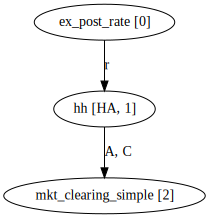

In [10]:
sj.drawdag(ha_simple)

This looks like the DAG from the class, except that we haven't specified the inputs, exogenous variables, or targets. That's actually how the model is stored on the computer, and then we need to give SSJ in we'll need to do this to solve the full model.

Let's proceed to solving for the steady state. We know that we need to solve for $\beta$ to hit the goods market clearing condition or (even better in practice) the asset market clearing condition. 

If we don't remember what we called $\beta$, we look for it in the `inputs` of the model. Recall that these are not ouputs of any block, so they give us the candidate unknowns and exogenous variables. 

In [11]:
ha_simple.inputs

OrderedSet(['beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'Y', 'r_ante'])

So we found `beta`. Similarly, if we don't remember what we call our market clearing conditions, we look for them among the model's `outputs`. These are not inputs into any block, so they give us the candidate targets of our model.

In [12]:
ha_simple.outputs

OrderedSet(['A', 'C', 'r', 'asset_mkt', 'goods_mkt'])

Now we get the steady state by calling the `solve_steady_state` function, giving it a reasonable range for `beta` to look over. We can check out the outcome steady state dict by calling `toplevel`.

In [13]:
ss['ha'] = models['ha'].solve_steady_state(calibration, {'beta': (0.75, 0.9)}, ['asset_mkt'])
ss['ha'].toplevel

{'eis': 0.5,
 'rho_e': 0.92,
 'sd_e': 0.92,
 'Y': 1.0,
 'r_ante': 0.01,
 'min_a': -1,
 'max_a': 1000,
 'n_a': 500,
 'n_e': 11,
 'beta': 0.823354842513158,
 'r': 0.01,
 'A': 6.556089005016474e-12,
 'C': 1.000000000000772,
 'asset_mkt': 6.556089005016474e-12,
 'goods_mkt': 7.720490913243339e-13}

Note that the calibration function filled up all the variables that are implicitly defined in the DAG, such as  `r`. 

To get the calibration of the ZL model, we just reset the minimal asset level on the grid and recalibrate. Of course, we'll get a much lower $\beta$ to clear the asset market at the same `r` but with much lower liquidity. 

In [14]:
calibration_zl = calibration.copy()
calibration_zl['min_a'] = -1e-6
ss['ha_zl'] = models['ha_zl'].solve_steady_state(calibration_zl, {'beta': (0.35, 0.85)}, ['asset_mkt'])

print(r'Beta in main model:', ss['ha']['beta'], ' ; in ZL model : ', ss['ha_zl']['beta'])

Beta in main model: 0.823354842513158  ; in ZL model :  0.4258741563912855


Finally, we calibrate the RA model. 

In [15]:
calibration_ra = calibration.copy()
calibration_ra['beta'] = 1 / (1 + calibration_ra['r_ante'])
ss['ra'] = models['ra'].solve_steady_state(calibration_ra, {'C': 1., 'A': 0.8}, {'budget_constraint': 0., 'asset_mkt': 0.},
                                           dissolve=['household_ra_simple'])

## Transition Dynamics: comparing HA and RA

Now that we have a steady state, let's compute some simple impulse responses.

To do this, we'll want to use `solve_impulse_linear`. If we don't remember the syntax, we can always look for the help. 


In [16]:
help(models['ha'].solve_impulse_linear)

Help on method solve_impulse_linear in module sequence_jacobian.blocks.block:

solve_impulse_linear(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, unknowns: List[str], targets: List[str], inputs: Union[Dict[str, Any], sequence_jacobian.classes.impulse_dict.ImpulseDict], outputs: Union[List[str], NoneType] = None, Js: Union[Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict], NoneType] = {}, options: Dict[str, dict] = {}, H_U_factored: Union[sequence_jacobian.classes.jacobian_dict.FactoredJacobianDict, NoneType] = None, **kwargs) -> sequence_jacobian.classes.impulse_dict.ImpulseDict method of sequence_jacobian.blocks.combined_block.CombinedBlock instance
    Calculate a general equilibrium, linear impulse response to a set of shocks in `inputs`
    around a steady state `ss`, given a set of `unknowns` and `targets` corresponding to the endogenous
    variables to be solved for and the target conditions that must hold in general equilibrium



We learn that we need to give this the model's steady state, and then `unknowns`, `targets`, and `inputs` (ie shocks). 

Again, `unknows` and `inputs` are among the model's inputs, and `targets` among the outputs.

Inspecting the above, `r_ante` is our shock, `Y` is our unknown, and `asset_market` our natural target.

If we want, we can visualize the dependencies including unknowns and targets using `drawdag` again called with optional arguments. 

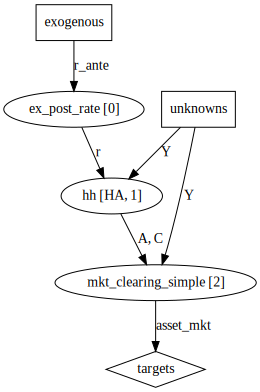

In [17]:
sj.drawdag(models['ha'], exogenous={'r_ante'}, unknowns={'Y'},targets={'asset_mkt'})

Now we are ready to look at the response of output to a decrease in the interest rate, with a per-period persistence of $0.7$

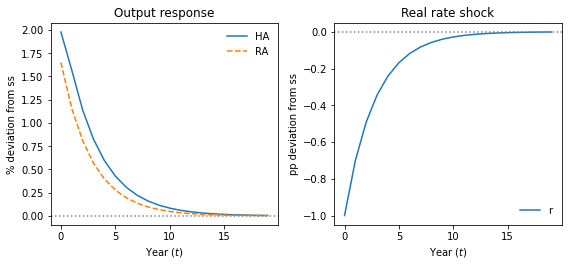

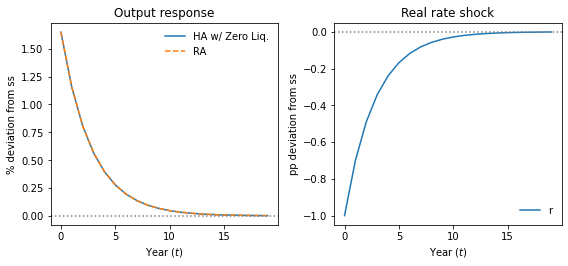

In [18]:
# Find the linear impulse responses to an "r" shock
T = 300
dr = -0.01 * 0.7 ** np.arange(T)
irf = {}
for m in ['ha', 'ha_zl', 'ra']:
    irf[m] = models[m].solve_impulse_linear(ss[m], ['Y'], ['asset_mkt'], {'r_ante': dr})

tutil.figure_1(irf, ss, dr)

This gives us the figures in the lecture: HA>RA in the baseline calibration, but HA=RA under zero liquidity. 

## Direct and indirect effects of monetary policy

Now let's decompose the total response into its constituent effects discussed in class - the "direct" effect from the `r` and the "indirect" effect from the `Y`, ie the endogenous response of labor demand in GE to increased consumption, resulting in more labor income and increased consumption, etc.

For this, we need to call the `jacobian` routine of SSJ, which gives us the Jacobians of any block's outputs with respect to its inputs. 

We can see what we need to give `jacobian` by calling the help again

In [19]:
help(models['ha']['hh'].jacobian)

Help on method jacobian in module sequence_jacobian.blocks.block:

jacobian(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, inputs: List[str], outputs: Union[List[str], NoneType] = None, T: Union[int, NoneType] = None, Js: Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict] = {}, options: Dict[str, dict] = {}, **kwargs) -> sequence_jacobian.classes.jacobian_dict.JacobianDict method of sequence_jacobian.blocks.het_block.HetBlock instance
    Calculate a partial equilibrium Jacobian to a set of `input` shocks at a steady state `ss`.



Here we see that `.jacobian` takes arguments (in order):
1. `SteadyStateDict` (the output of a call to `.steady_state`, or `.solve_steady_state`),
2. a `list` of inputs the user wants to calculate the Jacobian with respect to

Now we're ready to calculate the direct effect of a change in the interest rate on consumption. 

Note that, as the DAG shows us, going from the primitive `r` to the household block requires first going through the `ex_post_rate` block to get the ex-post rate from the ex-ante rate. What we really want is this combined Jacobian.

A simple way to do this is to form a `CombinedBlock`

In [20]:
ha_main = sj.combine([household_simple, ex_post_rate], name='ha_combined')
ha_main

<CombinedBlock 'ha_combined'>

We can now take the Jacobian of this block with respect to its two inputs `Y` and `r_ante`.

In [21]:
J = ha_main['ha_combined'].jacobian(ss['ha'],  inputs=['Y', 'r_ante'], T=T)

We use this to get the direct/indirect decomposition. 

In [22]:
dC, dC_dr, dC_dY = {}, {}, {}
dC['ha'] = irf['ha']['C']
dC_dr['ha'] = J['C']['r_ante']  @ dr
dC_dY['ha'] = J['C']['Y'] @ dC['ha']

Check that this the decomposition sums to the total: 

In [23]:
np.allclose(dC_dr['ha']+dC_dY['ha'], dC['ha'])

True

Now, we'll redo the same calculations in the RA model (getting the income effect from the IMPCs), and then compare the direct/indirect decomposition in both models. 

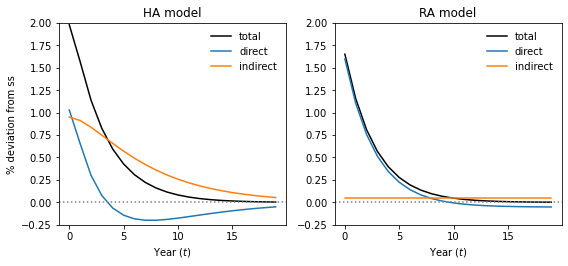

In [24]:
# Re-do the same calculations for the RA model
dC['ra'] = irf['ra']['C']

Mra = tutil.compute_ra_impcs(ss['ra']['beta'], T=T)
dC_dY['ra'] = Mra @ dC['ra']
dC_dr['ra'] = dC['ra'] - dC_dY['ra']


tutil.figure_2(dC, dC_dr, dC_dY)

We get back to the result from the lecture notes. 

## Cyclical income risk

Before we introduce cyclical income risk, let's look at the baseline case of an impulse response to a future, anticipated interest rate cut (forward guidance) with our baseline HA model with acyclical income risk.

A simple way to do this is to get the general equilibrium Jacobian of the model, which we obtain with `solve_jacobian`. Then, the $s$th column of that Jacobian gives us the impulse response to a forward-guidance `r` shock at date $s$. 

In [25]:
# Model jacobian in ra and ha models
T = 300
G = {}

G['ra'] = models['ra'].solve_jacobian(ss['ra'], ['Y'], ['asset_mkt'], ['r_ante'], T=T)
G['ha'] = models['ha'].solve_jacobian(ss['ha'], ['Y'], ['asset_mkt'], ['r_ante'], T=T)


Now let's plot this using `Tshock = 10`

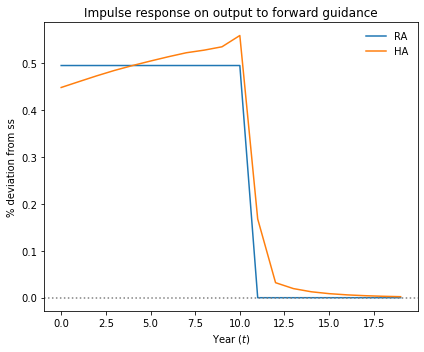

In [26]:
Tshock = 10
fig = plt.subplots(1, 1, figsize=(6, 5))
plt.plot(-G['ra']['Y']['r_ante'][:20, Tshock], label='RA')
plt.plot(-G['ha']['Y']['r_ante'][:20, Tshock], label='HA')
plt.axhline(y=0, color='#808080', linestyle=':')
plt.title('Impulse response on output to forward guidance')
plt.xlabel(r"Year $(t)$")
plt.ylabel('% deviation from ss')
plt.legend(framealpha=0)
plt.tight_layout()
#plt.savefig('Export/FG_RA_HA_incomeinc_lec2.pdf', format='pdf', transparent=True)
plt.show()

As discussed in class, the standard HA model with acyclical income risk does not solve the forward guidance puzzle. 

To go beyond this, we want to move away from income being just $e \times Y$, so that low-`e` agents are more or less sensitive to `Y`. 

To do this, we'll change the `income` hetinput. We'll use the following specification from Auclert \& Rognlie (2018)

$$ y_{it} = Y \cdot \frac{e_{it}^{1 + \zeta \log(Y)}}{\mathbb{E}[e_{it}^{1 + \zeta \log(Y)}]}$$

Call this new function `income_cyclical`. 

In [27]:
def income_cyclical(Y,e_grid, e_pdf, zeta):
    y = Y * e_grid ** (1 + zeta * np.log(Y)) / np.vdot(e_grid ** (1 + zeta * np.log(Y)), e_pdf)
    return y

This `hetinput` maps `zeta`, a variable that scales the degree of cyclicality of income risk, to `y` the post-tax labor income of households. When `zeta` = 0, income risk is acyclical but when `zeta` >/< 0, income risk is pro-/counter-cyclical

Note that this function requires the pdf of `e`. Since the standard SSJ implementation of `make_grids` doesn't this to us, we rewrite it here with this extra output.

In [28]:
def make_grids_pdf(rho_e, sd_e, n_e, min_a, max_a, n_a):
    e_grid, e_pdf, Pi = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    return e_grid, e_pdf, Pi, a_grid

We now define a new `hetblock` and a new `model` with this new functionality added. 

In [29]:
household_cyc = hh.add_hetinputs([make_grids_pdf, income_cyclical])
ha_cyc = sj.create_model([household_cyc, ex_post_rate, mkt_clearing_simple], name="HA Model with cyclical income risk")

In [30]:
calib_cyc = calibration.copy()
calib_cyc['zeta'] = -0.5

In [31]:
ss['ha_cyc'] = ha_cyc.solve_steady_state(calib_cyc, {'beta': (0.75, 0.9)}, ['asset_mkt'])

`zeta` should not change the steady state, we check this. 

In [32]:
np.isclose(ss['ha_cyc']['beta'], ss['ha']['beta'])

True

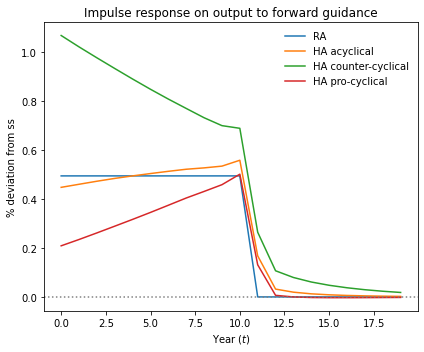

In [33]:
# Model jacobian in ha models with cyclical risk
for zeta, mod in zip([-0.5, 0.5], ['ha_counter', 'ha_pro']):
    ss_cyc = ss['ha_cyc'].copy()
    ss_cyc['zeta'] = zeta    # income risk does not change the steady state
    G[mod] = ha_cyc.solve_jacobian(ss_cyc, ['Y'], ['asset_mkt'], ['r_ante'], T=T)

tutil.figure_4(G)

## Maturity structure

As we saw in lecture, allowing for varying maturity/duration of assets can affect the equilibrium response of consumption to interest rate shocks. 

Recall the pricing (no-arbitrage) equation for Calvo bonds

$$
1 + r_t^{ante} = \frac{1 + \delta q_{t+1}}{q_t}
$$


We implement this equation as a `SolvedBlock` that returns `q` taking `r_ante` and `delta` as inputs

Recall from the fiscal tutorial that the syntax `q(1)` here would denote $q_{t+1}$, given `q` denotes $q_t$

In [34]:
@sj.solved(unknowns={'q': (0.1, 25)}, targets=['qres'], solver="brentq")
def longbonds_price(q, r_ante, delta):
    qres = q - (1 + delta * q(+1)) / (1 + r_ante)
    return qres

Additionally, we will create another block, which yields the ex-post return of the Calvo bonds. The reason we need this additional block is in this model there are valuation effects, i.e. when a shock occurs at period $t = 0$, it re-values the bond's price $q$ but because this shock was unanticipated as of $t = -1$, the actual realized return `r_post` will differ from the expected return as of $t = -1$, i.e. the $t = -1$ ex-ante rate

In [35]:
@sj.simple
def ex_post_longbonds_rate(q, delta):
    r = (1 + delta * q)/q(-1) - 1
    return r

Let's now create a new model object called `long`, solve for its steady state and recreate the figure we saw in lecture

In [36]:
calibration_long = calibration.copy()
calibration_long['delta'] = 0.95

models['long'] = sj.create_model([household_simple, ex_post_longbonds_rate, longbonds_price, mkt_clearing_simple], name="HA model with long-duration bonds")
ss['long'] = models['long'].solve_steady_state(calibration_long, {'beta': (0.75, 0.9)}, ['asset_mkt'])

If we want, we can get the DAG of this model and double-check it vs the lecture

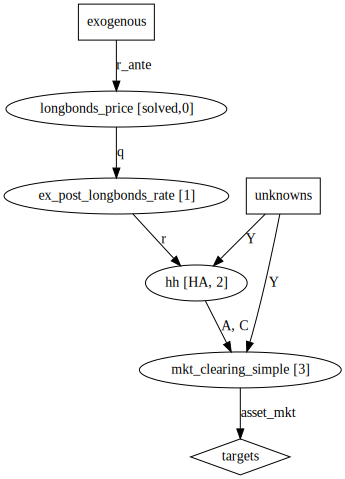

In [37]:
sj.drawdag(models['long'],exogenous={'r_ante'}, unknowns={'Y'},targets={'asset_mkt'})

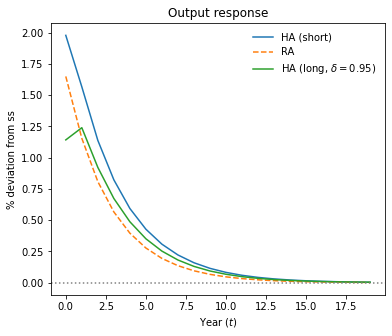

In [38]:
irf_long = {}
for mod in ['ha', 'ra', 'long']:
    hh_name = 'household_ra' if mod == 'ra' else 'household'
    irf_long[mod] = models[mod].solve_impulse_linear(ss[mod], ['Y'], ['asset_mkt'], {'r_ante': dr})

tutil.figure_5(irf_long, ss)

## Nominal assets - the "Fisher" effect

If instead of real assets households held nominal assets then in spite of following a real rate rule, inflation will matter due to a valuation effect on nominal debt due to inflation surprises, which we call the "Fisher effect"

First, we will build out the nominal side of the model, writing down a block to represent the New Keynesian Phillips Curve

In [39]:
@sj.simple
def nkpc(pi, Y, C, theta_w, vphi, frisch, markup_ss, eis, beta):
    kappa_w = (1 - theta_w) * (1 - beta * theta_w)/theta_w
    piw = pi
    piwres = kappa_w * (vphi * (Y)**(1/frisch) - 1/markup_ss * C**(-1/eis)) + beta * piw(1) - piw
    return piwres, piw


@sj.simple
def ex_post_nom_asset_rate(r_ante, pi):
    i = r_ante + pi(1)
    r = i(-1) - pi
    return r

calibration_nom_asset = calibration.copy()
calibration_nom_asset['pi'] = 0.  # look at the zero-inflation steady state
calibration_nom_asset['markup_ss'] = 1.015
calibration_nom_asset['theta_w'] = 0.66
calibration_nom_asset['frisch'] = 0.5

models['nom_assets'] = sj.create_model([household_simple, nkpc, ex_post_nom_asset_rate, 
                                        mkt_clearing_simple], name="HA model with nominal, short-term bonds")
ss['nom_assets'] = models['nom_assets'].solve_steady_state(calibration_nom_asset, {'beta': 0.8, 'vphi': 0.8},
                                                           ['asset_mkt', 'piwres'])

The DAG now here, as promised: 

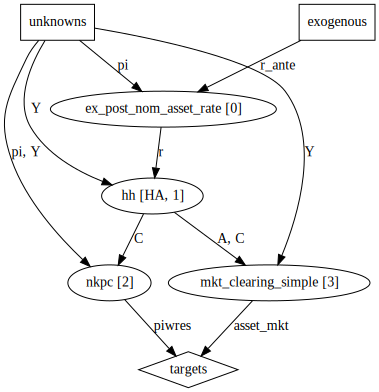

In [40]:
sj.drawdag(models['nom_assets'],exogenous={'r_ante'}, unknowns={'Y','pi'},targets={'asset_mkt','piwres'})

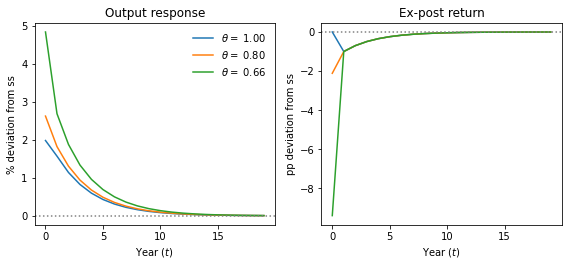

In [41]:
# Compute IRF in different models
G, irf_Y, irf_r_post = {}, {}, {}
theta_list = [1 - 1e-10, 0.8, 0.66]
for i, theta_w in enumerate(theta_list):
    calibration_theta = calibration_nom_asset.copy()
    calibration_theta["theta_w"] = theta_w
    ss_nom = models['nom_assets'].solve_steady_state(calibration_theta, {'beta': 0.8, 'vphi': 0.8}, ['asset_mkt', 'piwres'])
    irf_here = models['nom_assets'].solve_impulse_linear(ss_nom, ['Y', 'pi'], ['asset_mkt', 'piwres'], {'r_ante': dr})
    irf_Y[i], irf_r_post[i] = irf_here["Y"], irf_here["r"]

tutil.figure_6(theta_list, irf_Y, irf_r_post)

#### Exercise 1: obtaining the solution using the GE Jacobian

Instead of `solve_impulse_linear`, calculate the general equilibrium Jacobian using the `solve_jacobian` routine. Then, calculate the output response to the interest rate shock `dr`, and check that you get the same solution. 

**Solution**: We'll first look for the arguments of `solve_jacobian` by calling the help. 

In [42]:
help(ha_simple.solve_jacobian)

Help on method solve_jacobian in module sequence_jacobian.blocks.block:

solve_jacobian(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, unknowns: List[str], targets: List[str], inputs: List[str], outputs: Union[List[str], NoneType] = None, T: int = 300, Js: Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict] = {}, options: Dict[str, dict] = {}, H_U_factored: Union[sequence_jacobian.classes.jacobian_dict.FactoredJacobianDict, NoneType] = None, **kwargs) -> sequence_jacobian.classes.jacobian_dict.JacobianDict method of sequence_jacobian.blocks.combined_block.CombinedBlock instance
    Calculate a general equilibrium Jacobian to a set of `exogenous` shocks
    at a steady state `ss`, given a set of `unknowns` and `targets` corresponding to the endogenous
    variables to be solved for and the target conditions that must hold in general equilibrium



Just like above we need to specify the steady state, the unknown `Y`, the target `asset_market`, and the inputs (shock) `r_ante`, this time as a list rather than the input dict `{'r_ante': dr}`, and then `T`, which is the Jacobian truncation horizon. 

In [43]:
# Define shock and compute GE response of output
G_here = models['ha'].solve_jacobian(ss['ha'], ['Y'], ['asset_mkt'], ['r_ante'], T=T)

Now, we can calculate what the general equilibrium output response is to an interest rate shock

In [44]:
dY_here = G_here['Y']['r_ante'] @ dr

Finally, we check that this is the same solution as the above. 

In [45]:
np.allclose(dY_here, irf['ha']['Y'])

True

**Exercise 2**: Instead of using a `CombinedBlock` to get the direct effect of monetary policy through `r`, do the same by manually chaining the relevant Jacobians along the DAG using the matrix multiply (`@`) operator. 


**Solution**

In [46]:
J_r_rante = models['ha']['ex_post_rate'].jacobian(ss['ha'], ['r_ante'], T=T)['r']['r_ante']
J_C_r = models['ha']['hh'].jacobian(ss['ha'], ['r'], T=T)['C']['r']

dC_dr_manual = J_C_r @ J_r_rante @ dr

assert np.all(np.isclose(dC_dr['ha'], dC_dr_manual))

**Exercise 3**: Code up the fiscal policy model from class, replicate the result about the ranking of the output effect of monetary policy vs that of the fiscal effect on demand.

Take the initial steady state levels of $G = 0.2$ and $B = 0.5$ and set the adjustment coefficients $\phi_G = \phi_T = 0.1$.
Also, set the shock to the ex-ante interest rate to have an impact effect of 0.1 percentage point and a persistence of $0.7$

**Solution**

In [47]:
def income_fiscal(atw_n, e_grid):
    # post-tax labor income
    y = atw_n * e_grid
    return y

household_fiscal = hh.add_hetinputs([make_grids, income_fiscal])

@sj.simple
def fiscal_BB(r, B, G, Y):
    T = G + r * B
    atw_n = (Y - T)
    return T, atw_n


@sj.simple
def fiscal_Trule(r, G, B, Y):
    T = G + r * B
    atw_n = (Y - T)
    return T, atw_n


@sj.simple
def fiscal_Grule(r, T, B, Y):
    G = T - r * B
    atw_n = (Y - T)
    return G, atw_n


@sj.solved(unknowns={'B': 0}, targets=['Bres'], solver="brentq")
def fiscal_deficit_Trule(r, G, B, Tss, phi_T, Y):
    T = Tss + phi_T * (B(-1) - B.ss)
    Bres = (1 + r) * B(-1) + G - T - B
    atw_n = (Y - T)
    return T, Bres, atw_n


@sj.solved(unknowns={'B': 0}, targets=['Bres'], solver="brentq")
def fiscal_deficit_Grule(r, T, B, Gss, phi_G, Y):
    G = Gss - phi_G * (B(-1) - B.ss)
    Bres = (1 + r) * B(-1) + G - T - B
    atw_n = (Y - T)
    return G, Bres, atw_n


@sj.simple
def mkt_clearing_fiscal(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt

In [48]:
# Models with Fiscal Adjustment Dynamics
models["ha_BB"] = sj.create_model([household_fiscal, mkt_clearing_fiscal, ex_post_rate, fiscal_Trule],
                                  name="HA w/ T Rule")
models["ha_Trule"] = sj.create_model([household_fiscal, mkt_clearing_fiscal, ex_post_rate, fiscal_Trule],
                                     name="HA w/ T Rule")
models["ha_Grule"] = sj.create_model([household_fiscal, mkt_clearing_fiscal, ex_post_rate, fiscal_Grule],
                                     name="HA w/ G Rule")
models["ha_Deficit_Trule"] = sj.create_model([household_fiscal, mkt_clearing_fiscal, ex_post_rate, fiscal_deficit_Trule],
                                             name="HA w/ Deficit-Financed T Rule")
models["ha_Deficit_Grule"] = sj.create_model([household_fiscal, mkt_clearing_fiscal, ex_post_rate, fiscal_deficit_Grule],
                                             name="HA w/ Deficit-Financed G Rule")

In [49]:
# Solve for the steady state (the same for all models here)
calibration_fiscal = calibration.copy()
calibration_fiscal.update({'B': 0.5, 'G': 0.2})
ss['ha_fiscal'] = models['ha_BB'].solve_steady_state(calibration_fiscal, {'beta': (0.75, 0.9)}, ['asset_mkt'],
                                                     solver='brentq', ttol=1e-14)
ss['ha_fiscal']['Tss'] = ss['ha_fiscal']['T']
ss['ha_fiscal']['Gss'] = ss['ha_fiscal']['G']
ss['ha_fiscal']['phi_T'] = ss['ha_fiscal']['phi_G'] = 0.1

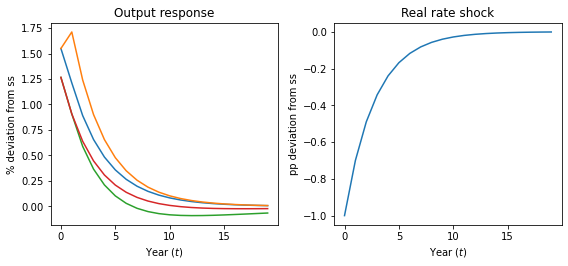

In [50]:
T = 300
dr_ante = -0.01 * 0.7 ** np.arange(T)

irf_fiscal = {}
m_list = ['ha_Trule', 'ha_Grule', 'ha_Deficit_Trule', 'ha_Deficit_Grule']
for m in m_list:
    irf_fiscal[m] = models[m].solve_impulse_linear(ss['ha_fiscal'], ['Y'], ['asset_mkt'], {'r_ante': dr_ante})

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.8))
ax1.set_title('Output response')
for m in m_list:
    ax1.plot(100 * irf_fiscal[m]['Y'][0:20], label=m)
ax1.set_ylabel('% deviation from ss')
ax1.set_xlabel(r"Year $(t)$")
ax2.set_title('Real rate shock')
ax2.plot(100 * dr[0:20])
ax2.set_xlabel(r"Year $(t)$")
ax2.set_ylabel('pp deviation from ss')
plt.tight_layout()
plt.show()

**Exercise 4**: Code up the investment model from class, replicate the result on the complementarity between HA and investment, using a *unit* shock to the ex-ante real interest rate with persistence $0.7$

In [51]:
@sj.simple
def firm(K, N, Z, alpha):
    Y = Z * K(-1) ** alpha * N ** (1 - alpha)
    mpk = alpha * Y / K(-1)
    w = (1 - alpha) * Y        # total earnings, NOT per unit of labor
    return Y, mpk, w


@sj.simple
def finance(q, K, mpk, deltaK, Psi):
    Q = mpk - (K/K(-1) - (1 - deltaK) + Psi/2 * (K/K(-1) - 1)**2) + K/K(-1) * q
    r = Q / q(-1) - 1
    asset = q * K
    return Q, r, asset


@sj.simple
def investment(q, Q, K, r_ante, deltaK, Psi):
    inv = Psi * (K/K(-1) - 1) + 1 - q
    val = q - Q(1)/(1 + r_ante)
    I = K - (1 - deltaK) * K(-1) + Psi/2 * (K/K(-1) - 1)**2 * K(-1)
    return inv, val, I


@sj.simple
def mkt_clearing_investment(A, asset, C, I, Y):
    asset_mkt = A - asset
    goods_mkt = C + I - Y
    return asset_mkt, goods_mkt

In [52]:
# Models with Investment
models['ha_inv'] = sj.create_model([household_simple, firm, finance, investment, mkt_clearing_investment],
                                   name="HA w/ Investment")

calibration_inv = calibration.copy()
calibration_inv.update({'eis': 1., 'r': 0.0125, 'N': 1., 'K': 1.21616, 'deltaK': 0, 'Psi': 1, 'q': 1.,
                        'rho_e': 0.85**(1/4), 'sd_e': 0.92, 'n_e': 7, 'min_a': 0., 'max_a': 4 * 1000, 'n_a': 500})
calibration_inv_highPsi = calibration_inv.copy()
calibration_inv_highPsi['Psi'] = 1e6

ss['ha_inv'] = models['ha_inv'].solve_steady_state(calibration_inv, {'beta': 0.95, 'alpha': 0.01, 'Z': 1.},
                                                   {'asset_mkt': 0., 'mpk': 0.0125, 'Y': 1.})
ss['ha_inv_highPsi'] = models['ha_inv'].solve_steady_state(calibration_inv_highPsi, {'beta': 0.95, 'alpha': 0.01, 'Z': 1.},
                                                           {'asset_mkt': 0., 'mpk': 0.0125, 'Y': 1.})

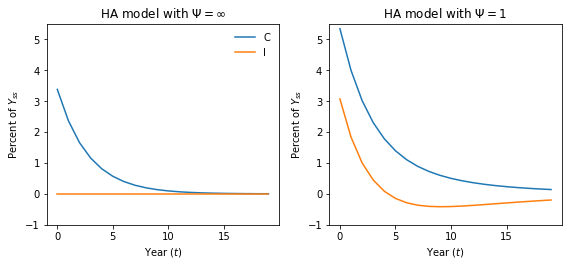

In [53]:
T = 300
dr_ante = -0.7 ** np.arange(T)

irf_inv = {}
for Psi in [1e6, 1]:
    irf_inv[Psi] = {}
    if Psi == 1:
        irf_inv_aux = models['ha_inv'].solve_impulse_linear(ss['ha_inv'], ['N', 'K', 'q'],
                                                            ['asset_mkt', 'inv', 'val'], {'r_ante': dr_ante})
        irf_inv[Psi]['C'], irf_inv[Psi]['I'] = irf_inv_aux['C'], irf_inv_aux['I']
    else:
        irf_inv_aux = models['ha_inv'].solve_impulse_linear(ss['ha_inv_highPsi'], ['N', 'K', 'q'],
                                                            ['asset_mkt', 'inv', 'val'], {'r_ante': dr_ante})
        irf_inv[Psi]['C'], irf_inv[Psi]['I'] = irf_inv_aux['C'], irf_inv_aux['I']

# Plot
Tplot = 20
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.8))
ax1.plot(irf_inv[1e6]['C'][:Tplot], label='C')
ax1.plot(irf_inv[1e6]['I'][:Tplot], label='I')
ax1.set_title(r"HA model with $\Psi=\infty$")
ax1.set_xlabel(r"Year $(t)$")
ax1.set_ylabel('Percent of $Y_{ss}$')
ax1.set_ylim([-1, 5.5])
ax1.legend(framealpha=0)
ax2.plot(irf_inv[1]['C'][:Tplot], label = 'C')
ax2.plot(irf_inv[1]['I'][:Tplot], label = 'I')
ax2.set_title(r"HA model with $\Psi=1$")
ax2.set_xlabel(r"Year $(t)$")
ax2.set_ylabel('Percent of $Y_{ss}$')
ax2.set_ylim([-1, 5.5])
plt.tight_layout()
plt.show()

**Exercise 5**: Code up the Taylor rule model from class, replicate the result on the effect of a monetary policy shock (a shock to the Taylor rule) depending on $\phi$

**Solution**

In [54]:
@sj.simple
def nkpc(pi, Y, X, C, theta_w, vphi, frisch, markup_ss, eis, beta):
    kappa_w = (1 - theta_w) * (1 - beta * theta_w)/theta_w
    piw = pi + X - X(-1)
    piwres = kappa_w * (vphi * (Y/X)**(1/frisch) - 1/markup_ss * X * C**(-1/eis)) + beta * piw(1) - piw
    return piwres, piw


@sj.simple
def monetary_taylor(pi, ishock, rss, phi_pi):
    i = rss + phi_pi * pi + ishock
    r_ante = i - pi(1)
    return i, r_ante

In [55]:
# Models with monetary policy through a standard nominal Taylor rule
models['ha_taylor'] = sj.create_model([household_simple, mkt_clearing_simple, nkpc,
                                       ex_post_rate, monetary_taylor], name='HA w/ Taylor Rule')
calibration_taylor = calibration.copy()
calibration_taylor.update({'X': 1., 'rss': calibration['r_ante'], 'pi': 0., 'ishock': 0.,
                           'phi_pi': 1.5, 'theta_w': 0.66, 'frisch': 0.5, 'markup_ss': 1.015})
ss['ha_taylor'] = models['ha_taylor'].solve_steady_state(calibration_taylor, {'beta': 0.8, 'vphi': 0.8}, ['asset_mkt', 'piwres'])

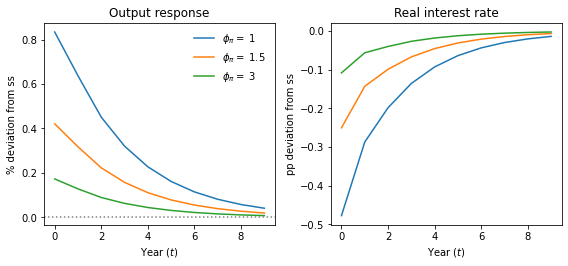

In [56]:
import copy

# Define shock
T = 300
di = -0.01 * 0.7 ** np.arange(T)

# Compute IRF in different models
G, irf_taylor_Y, irf_taylor_r = {}, {}, {}
irf_taylor_Y['ishock'], irf_taylor_Y['X'], irf_taylor_r['ishock'], irf_taylor_r['X'] = {}, {}, {}, {}
phi_pi_list = [1, 1.5, 3]
for phi_pi in phi_pi_list:
    calibration_theta = copy.deepcopy(calibration_taylor)
    calibration_theta['phi_pi'] = phi_pi
    ss = models['ha_taylor'].solve_steady_state(calibration_theta, {'beta': 0.8, 'vphi': 0.8}, ['asset_mkt', 'piwres'])
    irf_taylor_i = models['ha_taylor'].solve_impulse_linear(ss, ['Y', 'pi'], ['asset_mkt', 'piwres'], {'ishock': di})

    irf_taylor_Y['ishock'][phi_pi], irf_taylor_r['ishock'][phi_pi] = irf_taylor_i['Y'], irf_taylor_i['r_ante']

# Plot
Tplot = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.8))
ax1.set_title('Output response')
for m in phi_pi_list:
    ax1.plot(100 * irf_taylor_Y['ishock'][m][0:Tplot], label=fr'$\phi_\pi =$ {m}')
ax1.axhline(y=0, color='#808080', linestyle=':')
ax1.set_ylabel('% deviation from ss')
ax1.set_xlabel(r'Year $(t)$')
ax1.legend(framealpha=0)
ax2.set_title('Real interest rate')
for m in phi_pi_list:
    ax2.plot(100 * irf_taylor_r['ishock'][m][0:Tplot])
ax2.set_xlabel(r'Year $(t)$')
ax2.set_ylabel('pp deviation from ss')
plt.tight_layout()
plt.show()